# Регрессия на основе гауссовских процессов
* Документация по гауссовским процессам в библиотеке scikit-learn: http://scikit-learn.org/stable/modules/gaussian_process.html
* Материалы школы DeepBayes

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import copy

from scipy import stats
from itertools import product
from collections import Counter, defaultdict, OrderedDict
from itertools import combinations, product
from tqdm import tqdm
from pprint import pprint
import pickle as pkl

# sklearn
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge, pairwise_kernels
from sklearn.gaussian_process import GaussianProcessRegressor

from IPython.display import clear_output, display

# matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from matplotlib.colors import colorConverter
%matplotlib inline

titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize


matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['figure.figsize'] = (10, 8)    

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
#matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

/home/siri3us/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [2]:
DO_NOT_SAVE_IMAGES = True
if not DO_NOT_SAVE_IMAGES:
    ASML_DIR = os.getcwd().split('ASML-book')[0] + 'ASML-book'
    PICS_DIR = os.path.join(ASML_DIR, 'book', 'pics', 'gpr')

<a id='toc'></a>
# Содержание [[toc]](#toc)
* [Регрессия на основе гауссовских процессов: теория](#gpr_theory)
    * [Гауссовский случайный процесс](#gpr_theory_gpr)
    * [Апостериорная оценка значений процесса в случае отсутствия шума](#gpr_theory_noise_free)
    * [Апостериорная оценка значений процесса в случае наличия шума](#gpr_theory_noise)
    * [ Выбов параметров ковариационной функции (ядра)](#gpr_theory_mle)
    * [Гауссовские процессы в библиотеке sklearn](#gpr_sklearn)
        * [GauassianProcessRegressor](#doc_gpr)
        * [Доступные ядра в библиотеке sklearn](#gpr_sklearn_kernels)
    * [Устойчивость модели гауссовой регрессии](#gpr_sustainability)
    * [Восстановление зависимостей с помощью гауссовской регрессии](#gpr_example1)
    * [Визуализация правдоподобия](#gpr_mle_visualization)

$
\newcommand{\PI}{3.141592654}
\newcommand{\Sum}{\sum\limits}
\newcommand{\Int}{\int\limits}
\newcommand{\Lim}{\lim\limits}
\newcommand{\Intf}{\int\limits_{-\infty}^{+\infty}}
\newcommand{\Prod}{\prod\limits}
\newcommand{\Max}{\max\limits}
\newcommand{\Min}{\min\limits}
\newcommand{\Var}{\mathbb{V}}
\newcommand{\Exp}{\mathbb{E}}
\newcommand{\argmax}{\arg\max}
\newcommand{\argmin}{\arg\min}
\newcommand{\Cov}{\text{Cov}}
\newcommand{\Loss}{\mathcal{L}}
\newcommand{\LogLike}{\mathcal{L}}
\newcommand{\Like}{\ell}
\newcommand{\Risk}{\mathcal{R}}
\newcommand{\makebold}[1]{\boldsymbol{#1}}
\newcommand{\mean}[1]{\overline{#1}}
\newcommand{\avg}[1]{\left\langle #1 \right\rangle}
\newcommand{\eps}{\varepsilon}
\renewcommand{\epsilon}{\varepsilon}
\newcommand{\partfrac}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ttt}[1]{\texttt{#1}}
\newcommand{\term}[1]{\textbf{#1}}
\newcommand{\lp}{\left(}
\newcommand{\rp}{\right)}
\newcommand{\lf}{\left\{}
\newcommand{\rf}{\right\}}
\newcommand{\ls}{\left[}
\newcommand{\rs}{\right]}
\newcommand{\lv}{\left|}
\newcommand{\rv}{\right|}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\NN}{\mathbb{N}}
\newcommand{\ZZ}{\mathbb{Z}}
\newcommand{\Ecdf}[1]{\hat{F}_n(#1)}
\newcommand{\OPT}{\ensuremath{\mathrm{OPT}}}
\newcommand{\opt}{\ensuremath{\mathrm{opt}}}
\newcommand{\boot}{\ensuremath{\mathrm{boot}}}
\newcommand{\bias}{\ensuremath{\mathrm{bias}}}
\newcommand{\se}{\ensuremath{\mathrm{se}}}
\newcommand{\MSE}{\ensuremath{\mathrm{MSE}}}
\newcommand{\qm}{\ensuremath{\mathrm{qm}}}
\newcommand{\as}{\ensuremath{\mathrm{as}}}
\newcommand{\trace}{\mathrm{tr}}
\newcommand{\const}{\mathrm{const}}
\newcommand{\sign}{\mathrm{sign}}
\newcommand{\tr}{\mathrm{tr}}
\newcommand{\new}{\mathrm{new}}
\newcommand{\old}{\mathrm{old}}
\newcommand{\diag}{\mathrm{diag}}
\newcommand{\rank}{\mathrm{rg}}
\newcommand{\ML}{\mathrm{ML}}
\newcommand{\MP}{\mathrm{MP}}
\newcommand{\KL}{\mathrm{KL}}
\newcommand{\NV}{\mathrm{NV}}
\newcommand{\esttheta}{\hat{\theta}}
\newcommand{\estlambda}{\hat{\lambda}}
\newcommand{\estmu}{\hat{\mu}}
\newcommand{\estsigma}{\hat{\sigma}}
\newcommand{\estalpha}{\hat{\alpha}}
\newcommand{\estbeta}{\hat{\beta}}
\newcommand{\estxi}{\hat{\xi}}
\newcommand{\esttau}{\hat{\tau}}
\newcommand{\estpsi}{\hat{\psi}}
\newcommand{\esta}{\hat{a}}
\newcommand{\estb}{\hat{b}}
\newcommand{\estc}{\hat{c}}
\newcommand{\estd}{\hat{d}}
\newcommand{\estf}{\hat{f}}
\newcommand{\estp}{\hat{p}}
\newcommand{\esty}{\hat{y}}
\newcommand{\estT}{\hat{T}}
\newcommand{\estR}{\hat{R}}
\newcommand{\estF}{\hat{F}}
\newcommand{\estC}{\hat{C}}
\newcommand{\estS}{\hat{S}}
\newcommand{\estY}{\hat{Y}}
\newcommand{\estVar}{\hat{\Var}}
\newcommand{\estExp}{\hat{\Exp}}
\newcommand{\estSe}{\hat{\se}}
\newcommand{\ecdf}{\hat{F}}
\newcommand{\hata}{\hat{a}}
\newcommand{\hatb}{\hat{b}}
\newcommand{\hatc}{\hat{c}}
\newcommand{\hatd}{\hat{d}}
\newcommand{\hatf}{\hat{f}}
\newcommand{\hatg}{\hat{g}}
\newcommand{\hatk}{\hat{k}}
\newcommand{\hatp}{\hat{p}}
\newcommand{\hatr}{\hat{r}}
\newcommand{\hatt}{\hat{t}}
\newcommand{\haty}{\hat{y}}
\newcommand{\hatC}{\hat{C}}
\newcommand{\hatF}{\hat{F}}
\newcommand{\hatJ}{\hat{J}}
\newcommand{\hatK}{\hat{K}}
\newcommand{\hatY}{\hat{Y}}
\newcommand{\hateps}{\hat{\eps}}
\newcommand{\hatalpha}{\hat{\alpha}}
\newcommand{\hatbeta}{\hat{\beta}}
\newcommand{\hatpsi}{\hat{\psi}}
\newcommand{\hatlambda}{\hat{\lambda}}
\newcommand{\hattheta}{\hat{\theta}}
\newcommand{\hatsigma}{\hat{\sigma}}
\newcommand{\hatboldk}{\hat{\boldk}}
\newcommand{\hatSe}{\hat{\se}}
\newcommand{\hatExp}{\hat{\Exp}}
\newcommand{\hatVar}{\hat{\Var}}
\newcommand{\tilx}{\tilde{x}}
\newcommand{\tily}{\tilde{y}}
\newcommand{\tilX}{\tilde{X}}
\newcommand{\tilY}{\tilde{Y}}
\newcommand{\tilK}{\tilde{K}}
\newcommand{\tiltau}{\tilde{\tau}}
\newcommand{\tiltheta}{\tilde{\theta}}
\newcommand{\tillambda}{\tilde{\lambda}}
\newcommand{\tilsigma}{\tilde{\sigma}}
\newcommand{\tilpsi}{\tilde{\psi}}
\newcommand{\mlexi}{\xi_{MLE}}
\newcommand{\mletheta}{\theta_{MLE}}
\newcommand{\mlelambda}{\lambda_{MLE}}
\newcommand{\mlesigma}{\sigma_{MLE}}
\newcommand{\mlepsi}{\psi_{MLE}}
\newcommand{\mmxi}{\xi_{MM}}
\newcommand{\mmtheta}{\theta_{MM}}
\newcommand{\mmlambda}{\lambda_{MM}}
\newcommand{\mmsigma}{\sigma_{MM}}
\newcommand{\mmpsi}{\psi_{MM}}
\newcommand{\mmalpha}{\alpha_{MM}}
\newcommand{\mmbeta}{\beta_{MM}}
\newcommand{\Poisson}{\mathrm{Poisson}}
\newcommand{\Uniform}{\mathrm{Uniform}}
\newcommand{\Binomial}{\mathrm{Binomial}}
\newcommand{\Gammap}{\mathrm{Gamma}}
\newcommand{\Normal}{\mathcal{N}}
\newcommand{\LogN}{\mathrm{LogN}}
\newcommand{\Exponential}{\mathrm{Exp}}
\newcommand{\Erlang}{\mathrm{Erlang}}
\newcommand{\Cauchy}{C}
\newcommand{\Dir}{\mathrm{Dir}}
\newcommand{\Beta}{\mathrm{Beta}}
\newcommand{\Family}{\mathfrak{F}}
\newcommand{\RejectRegion}{R}
\newcommand{\pvalue}{\text{p-value}}
\newcommand{\llr}{\ell}
\newcommand{\Llr}{\mathcal{L}}
\newcommand{\RRS}{\mathrm{RSS}}
\newcommand{\redtext}[1]{\textcolor{red}{#1}}
\newcommand{\addtask}[1]{\hyperref[#1]{\redtext{Задача~\ref*{#1}}}}
\newcommand{\solution}{\redtext{\textbf{Решение.}}}
\newcommand{\ignore}[1]{}
\newcommand{\NumOfSamples}{\mathcal{N}}
\newcommand{\NumOfDims}{\mathcal{D}}
\newcommand{\NumOfHidden}{\mathcal{H}}
\newcommand{\NumOfClasses}{\mathcal{K}}
\newcommand{\NumOfChannels}{\mathcal{C}}
\newcommand{\NumOfFilters}{\mathcal{F}}
\newcommand{\HiddenSize}{\mathcal{H}}
\newcommand{\bolda}{\boldsymbol{a}}
\newcommand{\boldb}{\boldsymbol{b}}
\newcommand{\bolde}{\boldsymbol{e}}
\newcommand{\boldf}{\boldsymbol{f}}
\newcommand{\boldg}{\boldsymbol{g}}
\newcommand{\boldh}{\boldsymbol{h}}
\newcommand{\boldm}{\boldsymbol{m}}
\newcommand{\boldk}{\boldsymbol{k}}
\newcommand{\bolds}{\boldsymbol{s}}
\newcommand{\boldt}{\boldsymbol{t}}
\newcommand{\boldp}{\boldsymbol{p}}
\newcommand{\boldw}{\boldsymbol{w}}
\newcommand{\boldx}{\boldsymbol{x}}
\newcommand{\boldy}{\boldsymbol{y}}
\newcommand{\boldu}{\boldsymbol{u}}
\newcommand{\boldv}{\boldsymbol{v}}
\newcommand{\boldz}{\boldsymbol{z}}
\newcommand{\boldA}{\boldsymbol{A}}
\newcommand{\boldB}{\boldsymbol{B}}
\newcommand{\boldC}{\boldsymbol{C}}
\newcommand{\boldD}{\boldsymbol{D}}
\newcommand{\boldE}{\boldsymbol{E}}
\newcommand{\boldF}{\boldsymbol{F}}
\newcommand{\boldH}{\boldsymbol{H}}
\newcommand{\boldJ}{\boldsymbol{J}}
\newcommand{\boldK}{\boldsymbol{K}}
\newcommand{\boldM}{\boldsymbol{M}}
\newcommand{\boldI}{\boldsymbol{I}}
\newcommand{\boldP}{\boldsymbol{P}}
\newcommand{\boldR}{\boldsymbol{R}}
\newcommand{\boldS}{\boldsymbol{S}}
\newcommand{\boldT}{\boldsymbol{T}}
\newcommand{\boldO}{\boldsymbol{O}}
\newcommand{\boldU}{\boldsymbol{U}}
\newcommand{\boldV}{\boldsymbol{V}}
\newcommand{\boldW}{\boldsymbol{W}}
\newcommand{\boldX}{\boldsymbol{X}}
\newcommand{\boldY}{\boldsymbol{Y}}
\newcommand{\boldZ}{\boldsymbol{Z}}
\newcommand{\boldXY}{\boldsymbol{XY}}
\newcommand{\boldzero}{\boldsymbol{0}}
\newcommand{\boldalpha}{\boldsymbol{\alpha}}
\newcommand{\boldbeta}{\boldsymbol{\beta}}
\newcommand{\boldtheta}{\boldsymbol{\theta}}
\newcommand{\boldmu}{\boldsymbol{\mu}}
\newcommand{\boldxi}{\boldsymbol{\xi}}
\newcommand{\boldeta}{\boldsymbol{\eta}}
\newcommand{\boldpi}{\boldsymbol{\pi}}
\newcommand{\boldsigma}{\boldsymbol{\sigma}}
\newcommand{\boldphi}{\boldsymbol{\phi}}
\newcommand{\boldlambda}{\boldsymbol{\lambda}}
\newcommand{\boldeps}{\boldsymbol{\eps}}
\newcommand{\boldPhi}{\boldsymbol{\Phi}}
\newcommand{\boldLambda}{\boldsymbol{\Lambda}}
\newcommand{\hatboldK}{\hat{\boldK}}
\newcommand{\hatboldC}{\hat{\boldC}}
\newcommand{\hatboldy}{\hat{\boldy}}
\newcommand{\hatboldalpha}{\hat{\boldsymbol{\alpha}}}
\newcommand{\hatboldbeta}{\hat{\boldsymbol{\beta}}}
\newcommand{\hatboldtheta}{\hat{\boldsymbol{\theta}}}
\newcommand{\hatboldeps}{\hat{\boldsymbol{\eps}}}
\newcommand{\tilboldbeta}{\tilde{\boldbeta}}
\newcommand{\xs}[1]{\boldx^{(#1)}}
\newcommand{\ys}[1]{\boldy^{(#1)}}
\newcommand{\zs}[1]{\boldz^{(#1)}}
\newcommand{\Xs}[1]{\boldX^{(#1)}}
\newcommand{\Ys}[1]{\boldY^{(#1)}}
\newcommand{\Zs}[1]{\boldZ^{(#1)}}
\newcommand{\hatSigma}{\hat{\Sigma}}$

<a id='gpr_theory'></a>
# Регрессия на основе гауссовских процессов: теория [[toc]](#toc)

<a id='gpr_theory_gpr'></a>
### Гауссовский случайный процесс [[toc]](#toc) [[up]](#gpr_theory)

Рассмотрим случайный процесс $f(\boldx,\omega)$, где $\boldx \in \RR^d$ &mdash; индексирующий параметр,  $\omega \in \Omega$ &mdash; элементарный исход. Далее будем опускать $\omega$ и писать просто $f(\boldx)$. 

Рассмотрим совокупность значений $f(\boldx)$ в точках $\boldX = \{\boldx_1, \dots, \boldx_n\}$, т.е. **сечение процесса по $\boldX$** или **проекцию процесса на $\boldX$**. Далее будем обозначать
\begin{gather*}
\boldf(\boldX) \triangleq (f(\boldx_1), \dots, f(\boldx_n))^T.
\end{gather*}
**Случайный процесс $f(\boldx)$ называется гауссовским, если все его конечномерные распределения являются гауссовскими**
\begin{gather*}
p(\boldf(\boldX)) = p(f(\boldx_1), \dots, f(\boldx_n)) = \Normal(\boldf(\boldX)|\boldmu_{\boldX},\Sigma_{\boldX}),
\end{gather*}
где $\boldmu_{\boldX}$ &mdash; вектор средних значений и $\Sigma_{\boldX}$ &mdash; матрица ковариаций в общем случае зависящие от сечения $\boldX = \{\boldx_1, \dots, \boldx_n\}$:
\begin{gather*}
\Sigma_{\boldX} = 
\begin{pmatrix} 
K(\boldx_1, \boldx_1) &\dots  &K(\boldx_1, \boldx_n) \\
\vdots                &\ddots &\vdots    \\
K(\boldx_n, \boldx_1) &\dots  &K(\boldx_n, \boldx_n)  
\end{pmatrix} \in \RR^{n \times n}.
\end{gather*}

У **стационарного в узком смысле** гауссовского процесса вектор средних значений &mdash; константа, а ковариация между значениями случайного процесса $f(\boldx)$ в точках $\boldx_i$ и $\boldx_j$ зависит только от расстояния между этими точками:
\begin{gather*}
\boldmu_{\boldX} = \const,\\
K(\boldx_i, \boldx_j) \triangleq \Cov(f(\boldx_i), f(\boldx_j)) = K(\rho(\boldx_i, \boldx_j)).
\end{gather*}
Далее будем писать просто $K(\boldx_i, \boldx_j)$. Заметим, что при этом априорная дисперсия значения процесса в некоторой точке $\boldx$ одинакова для всех точек и равна $K(0)$:
\begin{gather*}
\Var \lp f(\boldx) \rp = \Cov(f(\boldx), f(\boldx)) = K(\boldx, \boldx) = K(0).
\end{gather*}
В силу неравенства Коши-Буняковского для стационарного в узком смысле процесса получаем:
$$
K(\boldx',\boldx'') = K(\rho(\boldx',\boldx'')) = \sqrt{K(\rho(\boldx', \boldx')) K(\rho(\boldx'',\boldx''))} = K(0). 
$$

На самом деле требование станционарности не является необходимым при работе с гауссовскими процессами, о чем мы убедимся далее.

<a id='gpr_theory_noise_free'></a>
### Апостериорная оценка значений процесса в случае отсутствия шума [[toc]](#toc) [[up]](#gpr_theory)

Требуется оценить значения процесса в точках $\boldY = \{\boldy_1, \dots, \boldy_m\}$. Введем следующие обозначения:
\begin{gather*}
\boldf(\boldY) \triangleq (f(\boldy_1), \dots, f(\boldy_m))^T,\\
\boldf(\boldX\boldY) \triangleq (f(\boldx_1), \dots, f(\boldx_n), f(\boldy_1), \dots, f(\boldy_m))^T.
\end{gather*}

По определению условной вероятности получаем
\begin{gather*}
p(\boldf(\boldY)|\boldf(\boldX)) = \frac{p(\boldf(\boldY),\boldf(\boldX))}{p(\boldX)}.
\end{gather*}
Матрица ковариаций для вектора $\boldf(\boldX\boldY)$ имеет вид:
\begin{gather*}
\Sigma_{\boldX\boldY} = \begin{pmatrix}
\Sigma_{\boldX} &\boldK_{\boldX,\boldY} \\
\boldK_{\boldX, \boldY} &\Sigma_{\boldY}
\end{pmatrix},
\end{gather*}
где 
\begin{gather*}
\Sigma_{\boldX} =
\begin{pmatrix} 
K(\boldx_1, \boldx_1) &\dots  &K(\boldx_1, \boldx_n) \\
\vdots                &\ddots &\vdots    \\
K(\boldx_n, \boldx_1) &\dots  &K(\boldx_n, \boldx_n)  
\end{pmatrix} \in \RR^{n \times n},\quad
\Sigma_{\boldY} =
\begin{pmatrix} 
K(\boldy_1, \boldy_1) &\dots  &K(\boldy_1, \boldy_m) \\
\vdots                &\ddots &\vdots    \\
K(\boldy_m, \boldy_1) &\dots  &K(\boldy_m, \boldy_m)  
\end{pmatrix} \in \RR^{m \times m},\quad
\boldK_{\boldX,\boldY} = 
\begin{pmatrix} 
K(\boldx_1, \boldy_1) &\dots  &K(\boldx_1, \boldy_m) \\
\vdots                &\ddots &\vdots    \\
K(\boldx_n, \boldy_1) &\dots  &K(\boldx_n, \boldy_m)  
\end{pmatrix} \in \RR^{n \times m}.
\end{gather*}

Можно показать, что 
\begin{align*}
&\boxed{p(\boldf(\boldY)|\boldf(\boldX)) = \frac{p(\boldf(\boldY),\boldf(\boldX))}{p(\boldX)} = \Normal(\boldf(\boldY)|\boldmu_{\boldY|\boldX}, \Sigma_{\boldY|\boldX})},\\
&\boxed{\boldmu_{\boldY|\boldX} = \boldmu_{\boldY} + \boldK^T \Sigma_{\boldX}^{-1} (\boldf(\boldX) - \boldmu_{\boldX})},\\
&\boxed{\Sigma_{\boldY|\boldX} = \Sigma_{\boldY} - \boldK^T\Sigma_{\boldX}^{-1}\boldK}.
\end{align*}

Если мы предсказываем значение в одной точке, т.е. $\boldY = \{\boldy\}$, тогда получим, что
\begin{align*}
&\boxed{p(f(\boldy)|\boldf(\boldX)) = \frac{p(f(\boldy),\boldf(\boldX))}{p(\boldX)} = \Normal(\boldf(\boldy)|\mu_{\boldy|\boldX}, \sigma_{\boldy|\boldX}^2)},\\
&\boxed{\mu_{\boldy|\boldX} = \boldmu_{\boldy} + \boldk^T(\boldy) \Sigma_{\boldX}^{-1} (\boldf(\boldX) - \boldmu_{\boldX})},\\
&\boxed{\sigma_{\boldy|\boldX}^2 = K(0) - \boldk^T(\boldy)\Sigma_{\boldX}^{-1}\boldk(\boldy)}.
\end{align*}

<a id='gpr_theory_noise'></a>
### Апостериорная оценка значений процесса в случае наличия шума [[toc]](#toc)  [[up]](#gpr_theory)

Дана выборка $(\boldX, \boldt) = \{ (\boldx_i, t_i) \}_{i = 1}^n$, $\boldx_i \in \RR^d$, $t_i \in \RR$. Вводится предположение о том, что наблюдаемые значения $\boldt$ &mdash; это зашумленная реализация $t(\boldX) = \lf t(\boldx_1), \dots, t(\boldx_n) \rf$ некоторого гауссовского случайного процесса $f(\boldx)$:
$$
t(\boldx) = \boldf(x) + \eps, \qquad \eps \sim \Normal(0, \sigma^2).
$$

Заметим, что $t(\boldx)$ также является гауссовским случайным процессом, потому как любое конечномерное распределение $p(\boldt(\boldX))$ является нормальным. Функция ковариации этого процесса связана с функцией ковариации $K(\cdot)$ процесса $f(\boldx)$ следующим образом:
\begin{gather*}
\hat{K}(\boldx_i, \boldx_j) = K(\boldx_i, \boldx_j) + \sigma^2 \delta_{\boldx_i, \boldx_j} =
\begin{cases}
K(\boldx_i, \boldx_j), &\boldx_i \neq \boldx_j,\\
K(0) + \sigma^2, &\boldx_i = \boldx_j.
\end{cases}
\end{gather*}
Поэтому
\begin{align*}
&\boxed{p(\boldf(\boldY)|\boldt(\boldX)) = \Normal(\boldf(\boldY)|\boldmu_{\boldY|\boldX}, \Sigma_{\boldY|\boldX})},\\
&\boxed{\boldmu_{\boldY|\boldX} = \boldmu_{\boldY} + \hat{\boldK}^T \hatSigma_{\boldX}^{-1}(\boldf(\boldX) - \boldmu_{\boldX})},\\
&\boxed{\Sigma_{\boldY|\boldX} = \hatSigma_{\boldY} - \hat{\boldK}^T\hatSigma_{\boldX}^{-1}\hat{\boldK}},\\
&\boxed{\hatSigma_{\boldX} = \Sigma_{\boldX} + \sigma^2 I, \qquad \hatSigma_{\boldY} = \Sigma_{\boldY} + \sigma^2 }.
\end{align*}

В случае предсказания в одной точке $\boldy$
\begin{align*}
&\boxed{p(\boldf(\boldy)|\boldt(\boldX)) = \Normal(f(\boldy)|\boldmu, \sigma^2(\boldy))},\\
&\boxed{\boldmu_{\boldy|\boldX} = \boldmu_{\boldy} + \hat{\boldk}^T(\boldy) \hatSigma_{\boldX}^{-1}(\boldf(\boldX) - \boldmu_{\boldX})},\\
&\boxed{\sigma_{\boldy|\boldX}^2 = \hat{\boldK}(0) - \hat{\boldk}^T(\boldy)\hatSigma_{\boldX}^{-1}\hat{\boldk}(\boldy)}.
\end{align*}

Занимательный факт состоит в том, что при попытке сделать прогноз в точке $\boldy = \boldx_i$, т.е. в точке, которая уже есть в выборке $\boldX$, получим
\begin{align*}
&\boxed{\boldmu(\boldx_i) = f(\boldx_i),\qquad \sigma^2(\boldx_i) = 0}.
\end{align*}
Этот результат верен только в том случае, если в выборке $\boldX$ точка $\boldx_i$ встречается ровно один раз. Иначе конечный результат будет является определенного рода усреднением всех достпных значений $f(\boldx)$ в этой точке.

Однако если точка $\boldy$ не совпадает ни с одной из точек $\boldX$, то
\begin{align*}
&\boxed{\boldmu_{\boldy|\boldX} = \boldmu_{\boldy} + \boldk^T(\boldy) (\Sigma_{\boldX} + \sigma^2\boldI_n)^{-1}(\boldf(\boldX) - \boldmu_{\boldX})},\\
&\boxed{\sigma_{\boldy|\boldX} = K(0) + \sigma^2 - \boldk^T(\boldy)(\Sigma_{\boldX} + \sigma^2 \boldI_n)^{-1}\boldk(\boldy)}.
\end{align*}

Таким образом, апостериорный прогноз на $f(\boldy)$ оказывается разрывным в точках выборки $\boldX$. Чтобы устранить этот разрыв, будем полагать, что 
\begin{align*}
&\mu_{\boldx_i|\boldX} = \lim_{\boldy \to \boldx_i} \mu_{\boldy|\boldX},
&\sigma_{\boldx_i|\boldX} = \lim_{\boldy \to \boldx_i} \sigma_{\boldy|\boldX},
\end{align*}
т.е. полагать, что последние две формулы применимы в любой точке $\boldy \in \RR^d$. Для случае нескольких точек $\boldY$ по аналогии получим
\begin{align*}
&\boxed{\boldmu_{\boldY|\boldX} = \boldmu_{\boldY} + \boldK^T (\Sigma_{\boldX} + \sigma^2 I)^{-1}(\boldf(\boldX) - \boldmu_{\boldX})},\\
&\boxed{\Sigma_{\boldY|\boldX} = \Sigma_{\boldY} + \sigma^2 I - \boldK^T(\Sigma_{\boldX} + \sigma^2 I)^{-1}\boldK}.
\end{align*}

Заметим, что значения для $\boldmu_{\boldy|\boldX}$ и $\sigma_{\boldy|\boldX}^2$ полученны именно для зашумленного процесса $t(\boldx)$, но нас интересует прогноз на значение $f(\boldy)$ незашумленного процесса. Несложно заметить, что шум не влияет на мат. ожидание процесса, однако увеличиывает на $\sigma^2$ дисперсию прогноза. Поэтому для среднего и дисперсии для $f(\boldY)$ получаем (с уже устраненными разрывами в точках выборки $\boldX$):
\begin{align*}
&\boxed{p(\boldf(\boldY)|\boldt(\boldX)) = \Normal(\boldf(\boldY)|\boldmu_{\boldY|\boldX}, \Sigma_{\boldY|\boldX})},\\
&\boxed{\boldmu_{\boldY|\boldX} = \boldmu_{\boldY} + \boldK^T (\Sigma_{\boldX} + \sigma^2 I)^{-1}(\boldf(\boldX) - \boldmu_{\boldX})},\\
&\boxed{\Sigma_{\boldY|\boldX} = \Sigma_{\boldY} - \boldK^T(\Sigma_{\boldX} + \sigma^2 I)^{-1}\boldK}.
\end{align*}
Или для одной точки $\boldy$:
\begin{align*}
&\boxed{p(\boldf(\boldy)|\boldt(\boldX)) = \Normal(\boldf(\boldy)|\boldmu_{\boldy|\boldX}, \Sigma_{\boldy|\boldX})},\\
&\boxed{\boldmu_{\boldy|\boldX} = \boldmu_{\boldY} + \boldk^T (\Sigma_{\boldX} + \sigma^2 I)^{-1}(\boldf(\boldX) - \boldmu_{\boldX})},\\
&\boxed{\Sigma_{\boldy|\boldX} = K(0) - \boldk^T(\Sigma_{\boldX} + \sigma^2 I)^{-1}\boldk}.
\end{align*}

<a id='gpr_theory_mle'></a>
### Выбов параметров ковариационной функции (ядра) [[toc]](#toc)  [[up]](#gpr_theory)
Зачастую ковариационная функция парамеризована некоторым набором параметров. Например, RBF-ядро обладает параметром $\gamma$ (зачастую именуемым `scale`):
$$
K(\boldx', \boldx'') = \exp\lp-\frac{\|\boldx' - \boldx''\|_2^2}{2\gamma}\rp.
$$
Соответственно возникает вопрос о том, как выбирать эти параметры. Обычно выбирают параметры, максимизирующие правдоподобие наблюдаемых данных:
$$
\boldtheta^* = \argmax_{\boldtheta} p(f(\boldX);\boldtheta).
$$
Заметим, что 

$$
K(\boldx', \boldx'') = \exp\lp-\frac{\|\boldx' - \boldx''\|_2^2}{2\gamma}\rp.
$$

Здесь присутствую сразу три параметра: 
* Коэффициент $C$ перед RBF-ядром
* Коэффициент масштабирования $\gamma$
* Дисперсия шума $\sigma^2$
Сложность нахождения этих параметров состоит в том, что логарифм правдоподобия
$$
\mathcal{L}(C,\gamma,\sigma^2;f(\boldX))
$$
обладает множеством локальных максимумов (ниже это будет продемонстриовано).
Поэтому зачастую приходится запускать численную процедуру максимизации правдободобия из многих
точек в множестве допустимых значений параметров.

<a id='gpr_sklearn'></a>
## Гауссовские процессы в библиотеке sklearn [[toc]](#toc) [[up]](#gpr_theory)

<a id='doc_gpr'></a>
### [GauassianProcessRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html) [[toc]](#toc) [[up]](#gpr_sklearn)

`GaussianProcessRegressor(kernel=None, alpha=1e-10, optimizer=’fmin_l_bfgs_b’, n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)`

Основные параметры GuassianProcessRegrossor, представляющие интерес:
* `kernel`:  **kernel object.** The kernel specifying the covariance function of the GP. If None is passed, the kernel “1.0 * RBF(1.0)” is used as default. Note that the kernel’s hyperparameters are optimized during fitting.
* `alpha`: **float or array-like, optional (default: 1e-10).** Value added to the diagonal of the kernel matrix during fitting. Larger values correspond to increased noise level in the observations. This can also prevent a potential numerical issue during fitting, by ensuring that the calculated values form a positive definite matrix. If an array is passed, it must have the same number of entries as the data used for fitting and is used as datapoint-dependent noise level. Note that this is equivalent to adding a WhiteKernel with c=alpha. Allowing to specify the noise level directly as a parameter is mainly for convenience and for consistency with Ridge.
* `n_restarts_optimizer`: **int, optional (default: 0).** The number of restarts of the optimizer for finding the kernel’s parameters which maximize the log-marginal likelihood. The first run of the optimizer is performed from the kernel’s initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. If greater than 0, all bounds must be finite. Note that n_restarts_optimizer == 0 implies that one run is performed.
* `normalize_y`: **boolean, optional (default: False).** Whether the target values y are normalized, i.e., the mean of the observed target values become zero. This parameter should be set to True if the target values’ mean is expected to differ considerable from zero. When enabled, the normalization effectively modifies the GP’s prior based on the data, which contradicts the likelihood principle; normalization is thus disabled per default.
* `copy_X_train`: **bool, optional (default: True).** If True, a persistent copy of the training data is stored in the object. Otherwise, just a reference to the training data is stored, which might cause predictions to change if the data is modified externally.
* `random_state`: **int, RandomState instance or None, optional (default: None).** The generator used to initialize the centers. If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

<a id='gpr_sklearn_kernels'></a>
### Доступные ядра в библиотеке sklearn [[toc]](#toc) [[up]](#gpr_sklearn)
Посмотрим на сечения гауссовских процессов с различными ядрами.

In [3]:
from sklearn.gaussian_process.kernels import Kernel, ConstantKernel, WhiteKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor

In [4]:
x_range = [0, 10]
n_points = 501
x_values = np.linspace(x_range[0], x_range[1], n_points)[:, None]

n_plots = 3
colors = ['k', 'gray', 'k']
linestyles = ['-', '-', '--']
plot_params = [{'color': colors[n_plot], 'linestyle': linestyles[n_plot]} 
               for n_plot in range(n_plots)]

kernels = OrderedDict()
kernels[0] = RBF(length_scale=1.0)
kernels[1] = RBF(length_scale=0.2)
kernels[2] = RBF(length_scale=1.0) + WhiteKernel(0.05)
kernels[3] = WhiteKernel(1.0)

kernel_labels = {0: 'RBF ($\gamma = 1$)',
                 1: 'RBF ($\gamma = 0.2$)',
                 2: 'RBF ($\gamma=1$) + white noise ($\sigma^2 = 0.05$)',
                 3: 'White noise ($\sigma^2=1$)'}

specific_plot_params = {0: {'linewidth': 1.5}, 
                        1: {'linewidth': 1.5},
                        2: {'linewidth': 0.7},
                        3: {'linewidth': 0.7}}
                    
n_kernels = len(kernels)

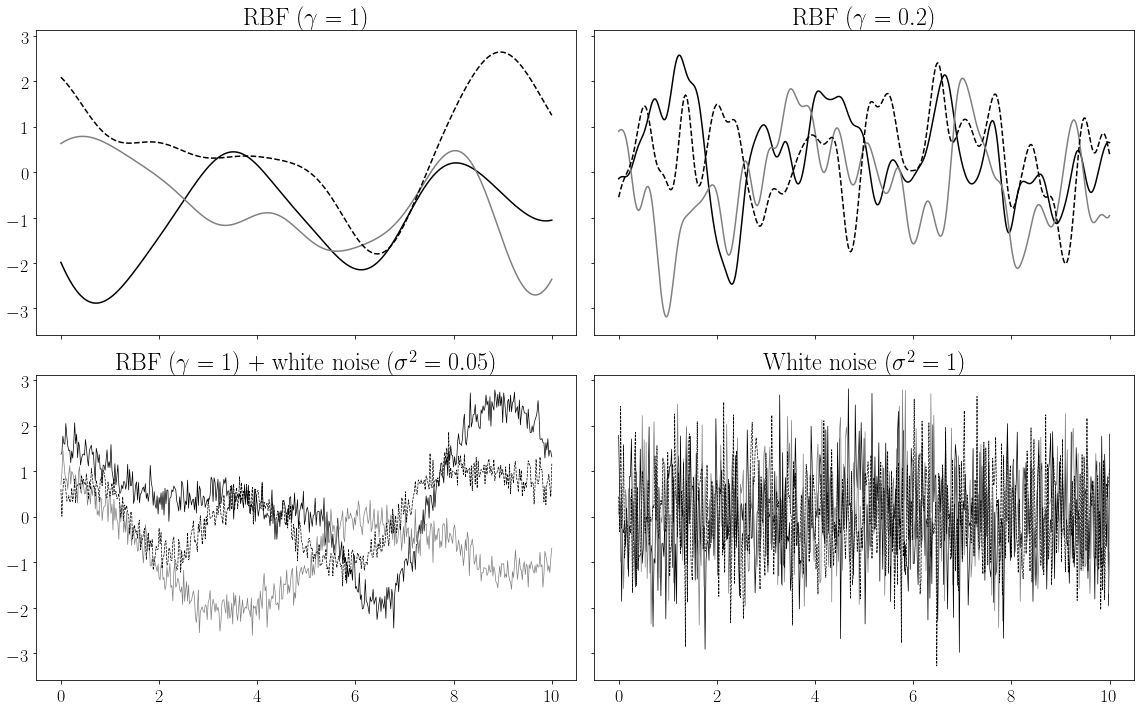

In [20]:
x_size = 8
y_size = 5
n_cols = 2
n_rows = int(np.ceil(n_kernels / n_cols))
fig, axarr = plt.subplots(n_rows, n_cols, figsize=(x_size * n_cols, y_size * n_rows), sharex=True, sharey=True)

for n_kernel in range(n_kernels):
    ax = axarr[n_kernel // n_cols, n_kernel % n_cols]
    kernel = kernels[n_kernel]
    gpr = GaussianProcessRegressor(kernel=kernel)
    for n_plot in range(n_plots):
        y_values = gpr.sample_y(x_values, random_state=n_kernel + n_plot)
        _plot_params = copy.deepcopy(plot_params[n_plot])
        for key, value in specific_plot_params[n_kernel].items():
            _plot_params[key] = value
        ax.plot(x_values.ravel(), y_values.ravel(), **_plot_params)
    ax.set_title(kernel_labels[n_kernel]);
plt.tight_layout()
if not DO_NOT_SAVE_IMAGES:
    plt.savefig(PICS_DIR + '/gpr_realizations.pdf', dpi=600, format='pdf')

/home/siri3us/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/siri3us/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/siri3us/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


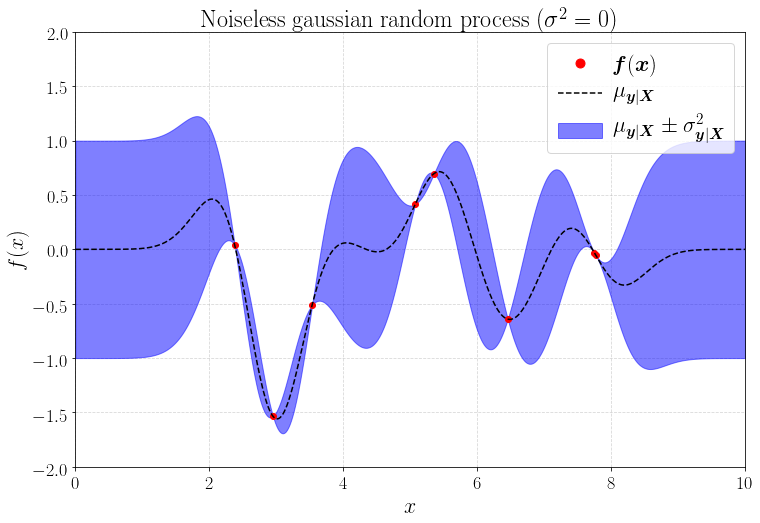

In [5]:
# Создание обучающей выборки
n_train_points = 8                 # Количество точек в обучающей выборке
x_train_points_range = [1.5, 8.5]  # Диапазон значений индексирующих параметров в обучающей выборке

kernel = RBF(0.5)
gpr = GaussianProcessRegressor(kernel)
np.random.seed(3)
X_train = np.random.uniform(x_train_points_range[0], x_train_points_range[1], size=(n_train_points, 1))
y_train = gpr.sample_y(X_train, random_state=4)

x_range = [0, 10]       # Диапазон значений для прогноза
n_pred_points = 501     # Количество точек, в которых будем делать прогноз
X_pred = np.linspace(x_range[0], x_range[1], n_points)[:, None]

# Обучение и предсказание
gpr.fit(X_train, y_train)
y_pred, y_pred_std = gpr.predict(X_pred, return_std=True)

# Отрисовка
plt.figure(figsize=(12, 8))
plt.plot(X_train.ravel(), y_train.ravel(), linestyle='none', color='r', marker='o', zorder=2,
        label=r'$\boldsymbol{f}(\boldsymbol{x})$')
plt.plot(X_pred.ravel(), y_pred.ravel(), linestyle='--', color='k', zorder=2,
         label=r'$\mu_{\boldsymbol{y}|\boldsymbol{X}}$')
plt.fill_between(X_pred.ravel(), y_pred.ravel() + y_pred_std, y_pred.ravel() - y_pred_std,
                 color='b', alpha=0.5, zorder=2,
                 label=r'$\mu_{\boldsymbol{y}|\boldsymbol{X}} \pm \sigma_{\boldsymbol{y}|\boldsymbol{X}}^2$')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.xlim(x_range); plt.ylim([-2, 2])
plt.xlabel(r'$x$'); plt.ylabel(r'$f(x)$')
plt.title(r'Noiseless gaussian random process ($\sigma^2 = 0$)')
plt.legend()
if not DO_NOT_SAVE_IMAGES:
    plt.savefig(PICS_DIR +  '/gpr_noise_free_pred.pdf')

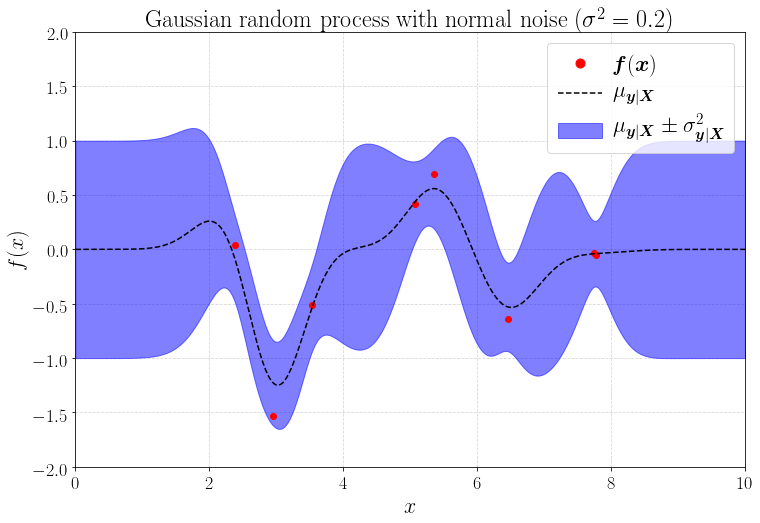

In [106]:
# Создание обучающей выборки
n_train_points = 8                 # Количество точек в обучающей выборке
x_train_points_range = [1.5, 8.5]  # Диапазон значений индексирующих параметров в обучающей выборке

kernel = RBF(0.5)
gpr = GaussianProcessRegressor(kernel, alpha=0.2)
np.random.seed(3)
X_train = np.random.uniform(x_train_points_range[0], x_train_points_range[1], size=(n_train_points, 1))
y_train = gpr.sample_y(X_train, random_state=4)

x_range = [0, 10]       # Диапазон значений для прогноза
n_pred_points = 501     # Количество точек, в которых будем делать прогноз
X_pred = np.linspace(x_range[0], x_range[1], n_points)[:, None]

# Обучение и предсказание
gpr.fit(X_train, y_train)
y_pred, y_pred_std = gpr.predict(X_pred, return_std=True)

# Отрисовка
plt.figure(figsize=(12, 8))
plt.plot(X_train.ravel(), y_train.ravel(), linestyle='none', color='r', marker='o', zorder=2,
        label=r'$\boldsymbol{f}(\boldsymbol{x})$')
plt.plot(X_pred.ravel(), y_pred.ravel(), linestyle='--', color='k', zorder=2,
         label=r'$\mu_{\boldsymbol{y}|\boldsymbol{X}}$')
plt.fill_between(X_pred.ravel(), y_pred.ravel() + y_pred_std, y_pred.ravel() - y_pred_std,
                 color='b', alpha=0.5, zorder=2,
                 label=r'$\mu_{\boldsymbol{y}|\boldsymbol{X}} \pm \sigma_{\boldsymbol{y}|\boldsymbol{X}}^2$')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.xlim(x_range); plt.ylim([-2, 2])
plt.xlabel(r'$x$'); plt.ylabel(r'$f(x)$')
plt.legend();
plt.title(r'Gaussian random process with normal noise ($\sigma^2 = 0.2$)')
if not DO_NOT_SAVE_IMAGES:
    plt.savefig(PICS_DIR + '/gpr_noisy_pred.pdf')

Заметим, что в точках обучающей выборки $\boldX$ прогноз строится как будто-то бы "с нуля", в противном случае в точках выборке апостериорное среднее $\mu_{\boldy|\boldX}$ было бы разрывно. Проблема устранения разрыва ранее была рассмотрена теоретически.

<a id='gpr_sustainability'></a>
## Устойчивость модели гауссовской регрессии [[toc]](#toc) [[up]](#gpr_theory)
Гауссовская регрессия без шума является крайне нестабильным алгоритмом для предсказания значений. Разберемся, почему.

Пусть в обучающей выборке $\boldX$ присутствуют два близкие точки $\boldx_i$ и $\boldx_j$, но их значения $f(\boldx_i)$ и $f(\boldx_j)$ существенно отличаются, т.е. реализация процесса претерпевает скачок в окрестности данных точек. В таком случае при максимизаци правдоподобия модель вынуждена подстроиться, чтобы объяснить этот резкий перепад значений. Резкий перепад в отсутствие шума может объяснить лишь быстро убывающая функция ковариации, но такие функцие ковариации практически бесполезны, так как они позволяют предсказать значения лишь в точках $\boldY$, близких к точкам обучающей выборки $\boldX$. Ниже наглядно изображено, что может произойти при наличии в данных хотя бы одного выброса. Выброс здесь генерируем сами. 

Разумеется, если данные действительно соответствует модели гауссовой регрессии без шума, то такого резкого перепада в них почти никогда не будет. Но на практике крайне редко можно наблюдать данные, о которых можно сказать, что в них гарантированно нет шума.

При использовании библиотеки `sklearn` мы работаем с классом `GaussianProcessRegressor`. Шум в данной модели можно задать двумя способами: как параметр ядра или как параметров `alpha` в конструкторе объекта.

Рассмотрим процесс подбора параметров в случае RBF-ядра:
$$
K(\boldx', \boldx'') = \exp \lp -\frac{\|\boldx' - \boldx''\|_2^2}{2\gamma} \rp.
$$
Чем "резче" упомянутый выше скачок между двумя соседними точками, тем меньшее значение параметра `lower_scale` ($\gamma$) подберет процедура максимизации правдоподобия. В таком случае будет получена быстро убывающая функция ковариации, практически не объясняющая зависимость между данными.

Fitted kernel: RBF(length_scale=0.159)
Fitted kernel: RBF(length_scale=1.07)


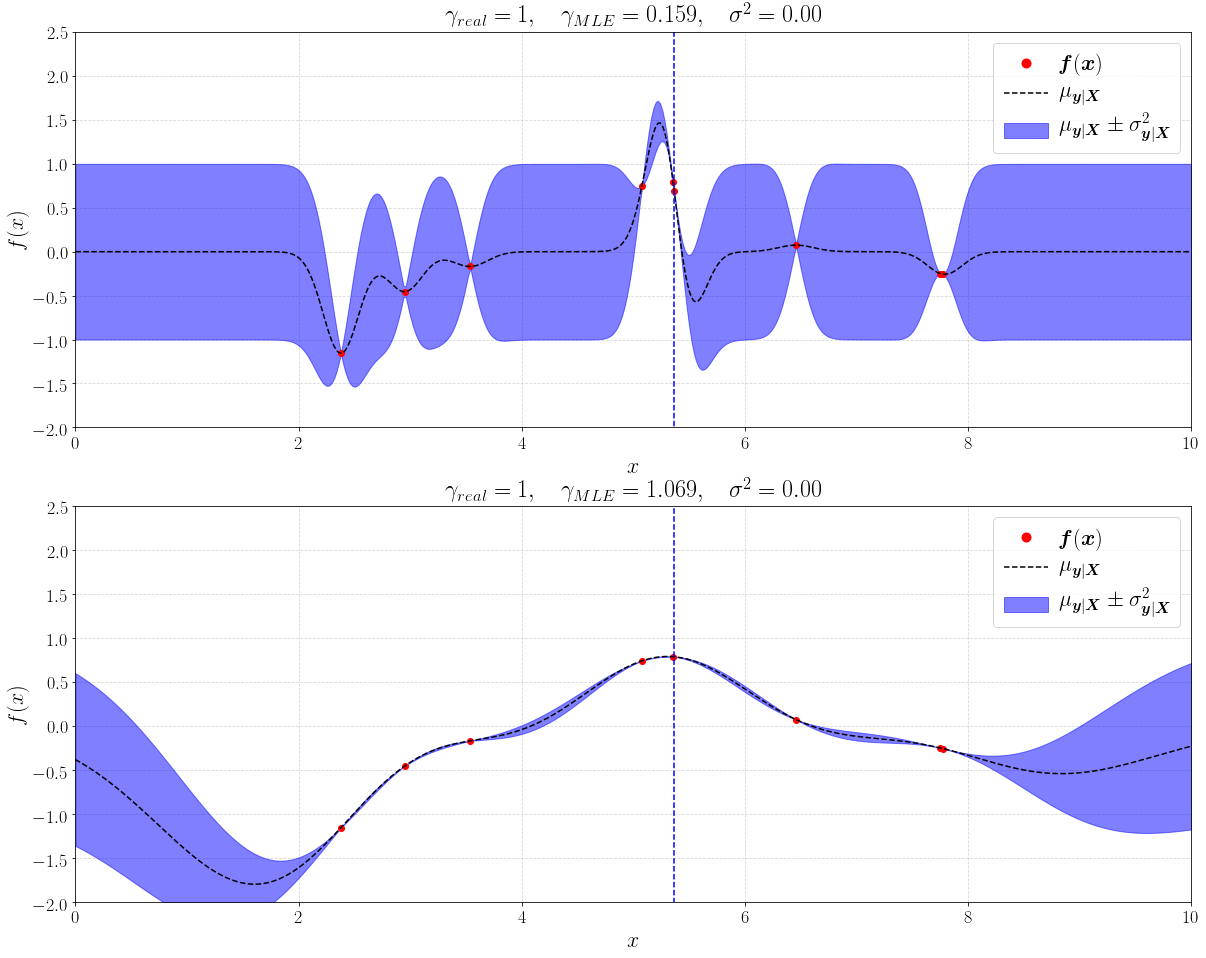

In [6]:
# Создание обучающей выборки с двуями близкими индексирующими параметрами
n_train_points = 8                 # Количество точек в обучающей выборке
x_train_points_range = [1.5, 8.5]  # Диапазон значений индексирующих параметров в обучающей выборке
y_range = [-2, 2.5]

real_scale = 1  # Истинный параметр ковариационной функции, которая порождает обучающую выборку
real_alpha = 1e-10

fig, axarr = plt.subplots(2, 1, figsize=(20, 16))
x_new_value = None

for n_plot, add_noisy_point in enumerate([True, False]):
    # Диапазон значений scale-а: (1e-3, 1). Изначально генерируем данные для scale=1
    kernel = RBF(real_scale, length_scale_bounds=(1e-3, 5))
    gpr = GaussianProcessRegressor(kernel, alpha=real_alpha, n_restarts_optimizer=10)
    np.random.seed(3)
    X_train = np.random.uniform(x_train_points_range[0], x_train_points_range[1], size=(n_train_points, 1))
    y_train = gpr.sample_y(X_train, random_state=4)

    if add_noisy_point:
        x_new_value = X_train[0, 0] + 0.01
        y_new_value = y_train[0, 0] - 0.1

        X_train = np.vstack([X_train, np.array([[x_new_value]])])
        y_train = np.vstack([y_train, np.array([[y_new_value]])])

    x_range = [0, 10]       # Диапазон значений для прогноза
    n_pred_points = 501     # Количество точек, в которых будем делать прогноз
    X_pred = np.linspace(x_range[0], x_range[1], n_points)[:, None]
    gpr.fit(X_train, y_train)
    print('Fitted kernel:', gpr.kernel_)
    y_pred, y_pred_std = gpr.predict(X_pred, return_std=True)

    # Отрисовка
    axarr[n_plot].plot(X_train.ravel(), y_train.ravel(), linestyle='none', color='r', marker='o', zorder=2,
             label=r'$\boldsymbol{f}(\boldsymbol{x})$')
    axarr[n_plot].plot(X_pred.ravel(), y_pred.ravel(), linestyle='--', color='k', zorder=2,
                       label=r'$\mu_{\boldsymbol{y}|\boldsymbol{X}}$')
    axarr[n_plot].fill_between(X_pred.ravel(), y_pred.ravel() + y_pred_std, y_pred.ravel() - y_pred_std,
                     color='b', alpha=0.5, zorder=2,
                               label=r'$\mu_{\boldsymbol{y}|\boldsymbol{X}} \pm \sigma_{\boldsymbol{y}|\boldsymbol{X}}^2$')
    axarr[n_plot].axvline(x_new_value, y_range[0], y_range[1], color='b', linestyle='--')
    axarr[n_plot].grid(which='both', linestyle='--', alpha=0.5)
    axarr[n_plot].set_xlim(x_range)
    axarr[n_plot].set_ylim(y_range)
    axarr[n_plot].set_xlabel(r'$x$')
    axarr[n_plot].set_ylabel(r'$f(x)$')
    axarr[n_plot].set_title('$\gamma_{{real}} = {},\quad \gamma_{{MLE}} = {:.3f},\quad \sigma^2 = {:.2f}$'
                            .format(real_scale, gpr.kernel_.length_scale, real_alpha))
    axarr[n_plot].legend()

if not DO_NOT_SAVE_IMAGES:
    if alpha <= 1e-10:
        plt.savefig(PICS_DIR + '/gpr_singularity.pdf')
    else:
        plt.savefig(PICS_DIR + '/gpr_singularity_solved.pdf')

Таким образом, даже одна зашумленная точка может сломать гауссовскую регрессию. В то же время достаточно предположить наличие шума, как ситуация выправляется: поставьте выше `real_alpha = 0.05` и убедитесь в этом.

<a id='gpr_example1'></a>
## Восстановление зависимостей с помощью гауссовской регрессии [[toc]](#toc) [[up]](#gpr_theory)

In [7]:
import inspect
from sklearn.gaussian_process import GaussianProcess, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C

Мы рассмотрим гауссовскую регрессию для аппроксимации следующих функций:
$$
f_1(x) = \cos(x),\\
f_2(x) = x \sin(x), \\
f_3(x) = 
\begin{cases} 5 - x^2, x < 2 \\ 13x - 1, x \ge 2 
\end{cases}.
$$

In [8]:
def f1(x):
    return np.cos(x)

def f2(x):
    return x * np.sin(x)

def f3(x):
    return np.array([5 - x[i] ** 2 if x[i] < 2 else 13 * x[i] - 1 for i in range(len(x))])

FUNCTIONS_SET = {'f1': f1, 
                 'f2': f2,
                 'f3': f3}

In [9]:
def plot_it(x, function, X, y, y_pred, dy=None, sigma=1.0, alpha=0.05, ax=None, figsize=(10, 8)):
    """
    -x: array-like
        Points at which we compare our predictions (y_pred) with real values of the estimated function.
    -function: callable
        Real function which are being estimated. 
    -X: array-like
        These are x points of the training set we have.
    -y: array-like
        These are y values of the training set we have.
    -y_pred: These are predictions we have made based on GPR.
    -dy:      Real variance of the noise at points X
    -sigma:   Noise variance.
    -alpha:   It is the parameter of the confidence interval.
    -ax:      Axis to plot the data on.
    -figsize: 
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    # Plotting true function at requested points
    ax.plot(x, function(x), 'r:', label=u'true function', zorder=2) 
    ax.plot(X, y, 'r.', markersize=6, label=u'Observations/Constraints', zorder=2)
    # Plotting predicted samples at requested points
    ax.plot(x, y_pred, 'b-', label=u'Prediction', zorder=2) 
    if dy is not None:
        # Plotting real noise variance at training points x
        plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=6, label=u'Real noise variance $\\sigma^2(x)$')
        
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred + scipy.stats.norm.ppf(alpha / 2) * sigma,
                            (y_pred + scipy.stats.norm.ppf(1 - alpha / 2) * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label=r'95\% confidence interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend(loc='best')
    plt.grid(which='both', linestyle='--', alpha=0.5)

### Пример без случайного шума (Noise-free case) [[toc]](#toc) [[up]](#gpr_theory)

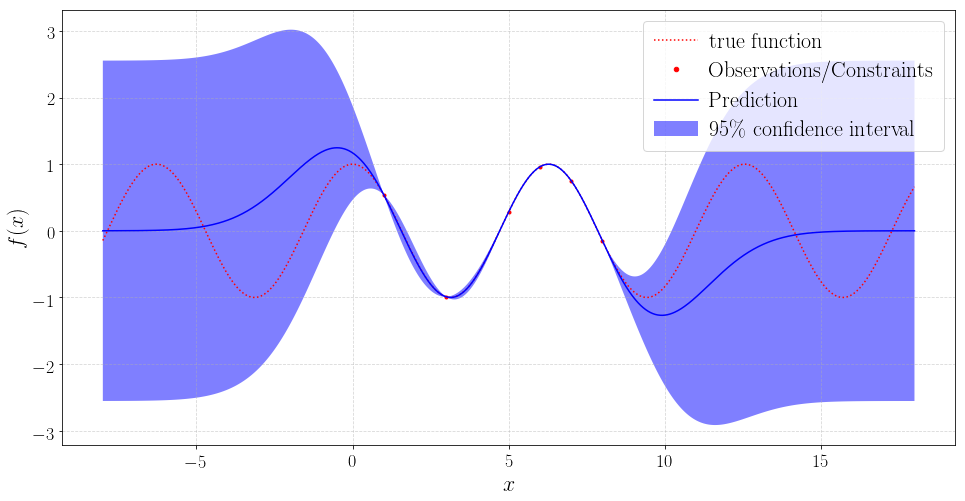

In [10]:
f = FUNCTIONS_SET['f1']
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T # add point 12
y = np.array(f(X)).ravel()

x = np.atleast_2d(np.linspace(-8, 18, 1000)).T # increase the range

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1)
gpr.fit(X, y)
y_pred, sigma = gpr.predict(x, return_std=True)
plot_it(x=x, function=f, X=X, y=y, y_pred=y_pred, sigma=sigma, figsize=(16, 8))

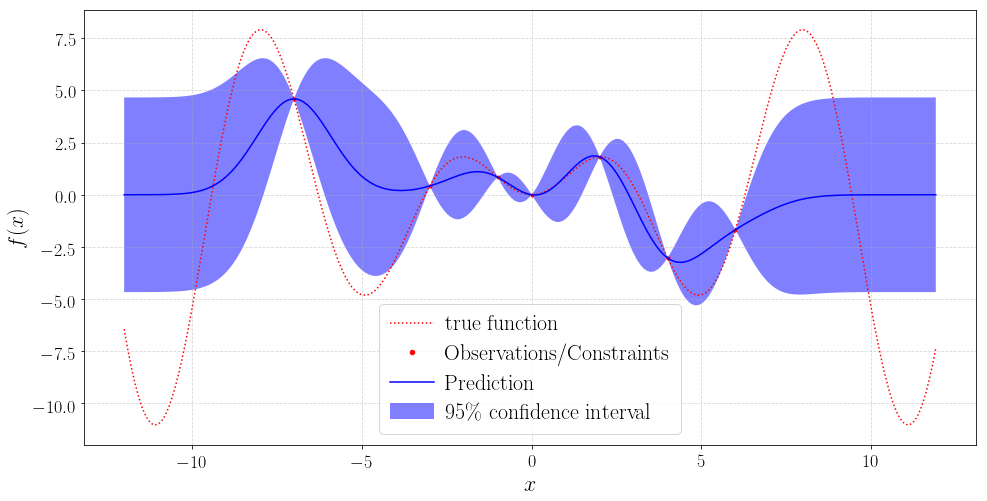

In [115]:
f = FUNCTIONS_SET['f2']
X = np.atleast_2d([-7, -3, -1, 0, 2, 4, 6]).T
y = np.array(f(X)).ravel()

x = np.atleast_2d(np.arange(-12, 12, 0.1)).T

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 5e1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=5)
gpr.fit(X, y)
y_pred, sigma = gpr.predict(x, return_std=True)

plot_it(x=x, function=f, X=X, y=y, y_pred=y_pred, sigma=sigma, figsize=(16, 8))

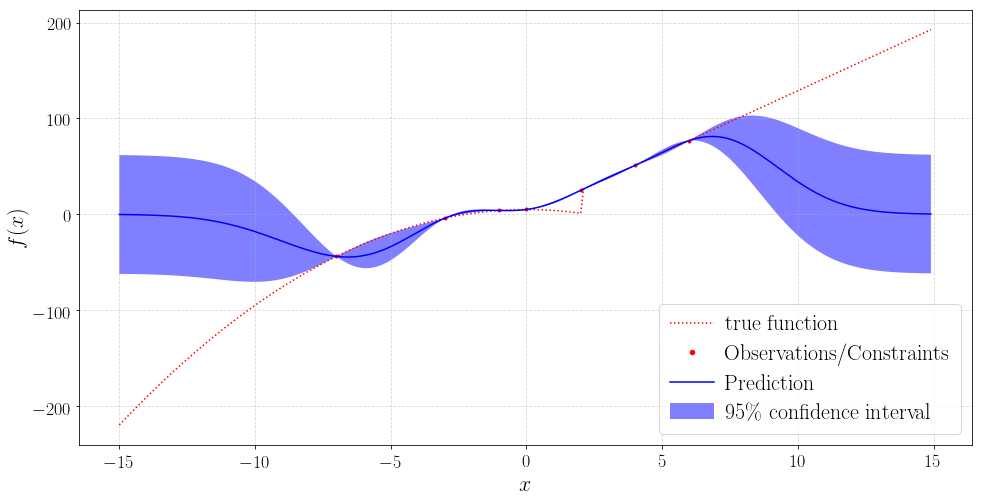

In [11]:
f = FUNCTIONS_SET['f3']
X = np.atleast_2d([-7, -3, -1, 0, 2, 4, 6]).T
y = np.array(f(X)).ravel()

x = np.atleast_2d(np.arange(-15, 15, 0.1)).T

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 5e1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gpr.fit(X, y)
y_pred, sigma = gpr.predict(x, return_std=True)

plot_it(x=x, function=f, X=X, y=y, y_pred=y_pred, sigma=sigma, figsize=(16, 8))

### Пример со случайным шумом (Noisy case) [[toc]](#toc)
Стоит умпомянуть, что параметр `alpha` у `GuassianProcessRegressor` не обязательно должен быть скаляром: он может быть задан вектором, каждая из компонент которого показывает уровень шума в конкретной точке обучающей выборки. И действительно, в выкладках, касающихся гауссовской регрессии с шумом, присутствует матрица
$$
\hatSigma_{\boldX} = \Sigma_{\boldX} + \sigma^2 I.
$$
В то же время в выкладках ничего не изменится, если заменить фиксированную дисперсию $\sigma^2$ в каждой точке на зависящую от точки $\boldx$ величину $\sigma^2(\boldx)$:
$$
\hatSigma_{\boldX} = \Sigma_{\boldX} + \diag(\sigma^2(\boldx_1), \dots, \sigma^2(\boldx_n)) = \Sigma_{\boldX} + \Lambda.
$$

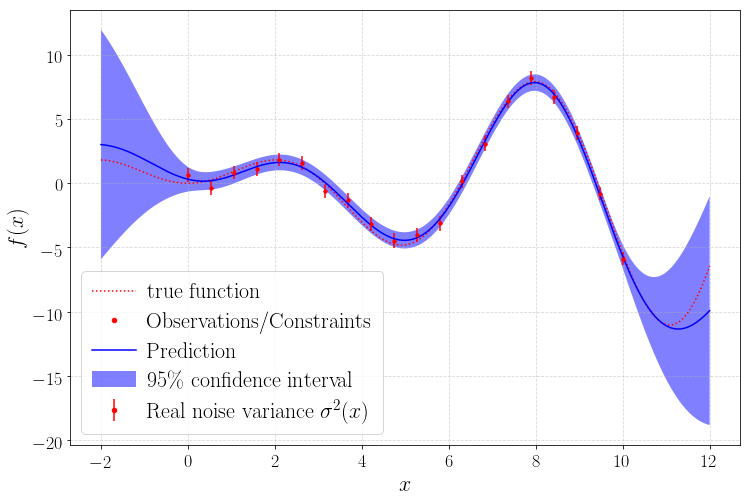

In [12]:
f = FUNCTIONS_SET['f2']
X = np.linspace(0, 10, 20) # x samples used for training
X = np.atleast_2d(X).T
y = np.array(f(X)).ravel()

# Now we generate the noise
np.random.seed(1)
dy = 0.5 + .1 * np.random.random(y.shape)
noise = np.random.normal(0, dy) # generating noise
y = y + noise                   # adding noise to the points

x = np.atleast_2d(np.linspace(-2, 12, 1000)).T # increase the range

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy**2, n_restarts_optimizer=10, random_state=1)
gp.fit(X, y)
y_pred_noise, sigma_noise = gp.predict(x, return_std=True)

plot_it(x=x, function=f, X=X, y=y, y_pred=y_pred_noise, sigma=sigma_noise, dy=dy, figsize=(12, 8))

<a id='gpr_mle_visualization'></a>
## Визуализация правдоподобия [[toc]](#toc) [[up]](#gpr_theory)

Fitted kernel: RBF(length_scale=0.353) + WhiteKernel(noise_level=0.168)
Fitted loglikelihood: -21.985447873728248


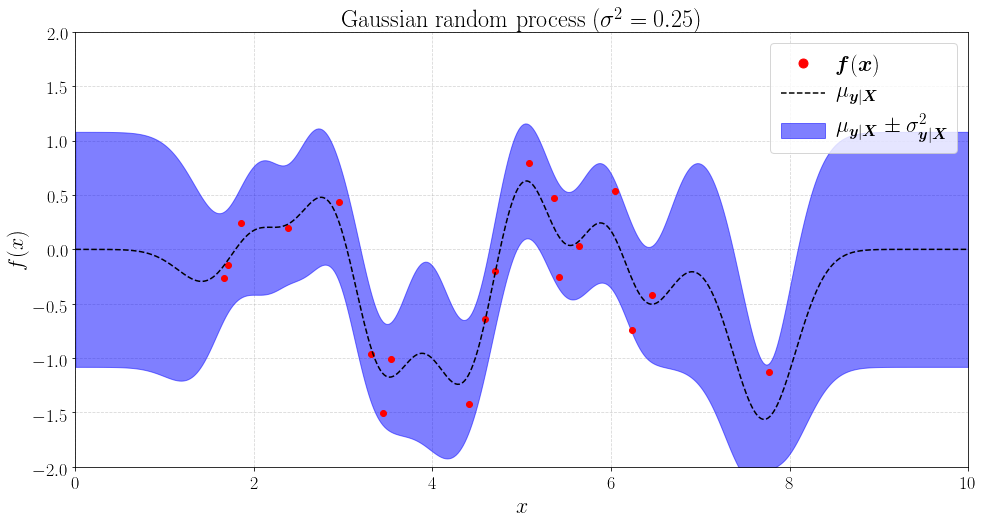

In [13]:
# Создание обучающей выборки
n_train_points = 20                # Количество точек в обучающей выборке
x_train_points_range = [1.5, 8.5]  # Диапазон значений индексирующих параметров в обучающей выборке
real_noise_level = 0.25
real_scale = 0.25

kernel = RBF(real_scale, (1e-3, 1e4)) +\
         WhiteKernel(noise_level=real_noise_level, noise_level_bounds=(1e-10, 1e4))
gpr = GaussianProcessRegressor(kernel, n_restarts_optimizer=1)
np.random.seed(3)
X_train = np.random.uniform(x_train_points_range[0], x_train_points_range[1], size=(n_train_points, 1))
y_train = gpr.sample_y(X_train, random_state=4)

x_range = [0, 10]       # Диапазон значений для прогноза
n_pred_points = 501     # Количество точек, в которых будем делать прогноз
X_pred = np.linspace(x_range[0], x_range[1], n_points)[:, None]

# Обучение и предсказание
gpr.fit(X_train, y_train)
print('Fitted kernel:', gpr.kernel_)
print('Fitted loglikelihood:', gpr.log_marginal_likelihood_value_)
y_pred, y_pred_std = gpr.predict(X_pred, return_std=True)

# Отрисовка аппроксимации
plt.figure(figsize=(16, 8))
plt.plot(X_train.ravel(), y_train.ravel(), linestyle='none', color='r', marker='o', zorder=2,
        label=r'$\boldsymbol{f}(\boldsymbol{x})$')
plt.plot(X_pred.ravel(), y_pred.ravel(), linestyle='--', color='k', zorder=2,
         label=r'$\mu_{\boldsymbol{y}|\boldsymbol{X}}$')
plt.fill_between(X_pred.ravel(), y_pred.ravel() + y_pred_std, y_pred.ravel() - y_pred_std,
                 color='b', alpha=0.5, zorder=2,
                 label=r'$\mu_{\boldsymbol{y}|\boldsymbol{X}} \pm \sigma_{\boldsymbol{y}|\boldsymbol{X}}^2$')
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.xlim(x_range)
plt.ylim([-2, 2])
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.title(r'Gaussian random process ($\sigma^2 = {}$)'.format(real_noise_level))
plt.legend()

Визуализируем значения возможных правдоподобий при различных параметрах ядра.

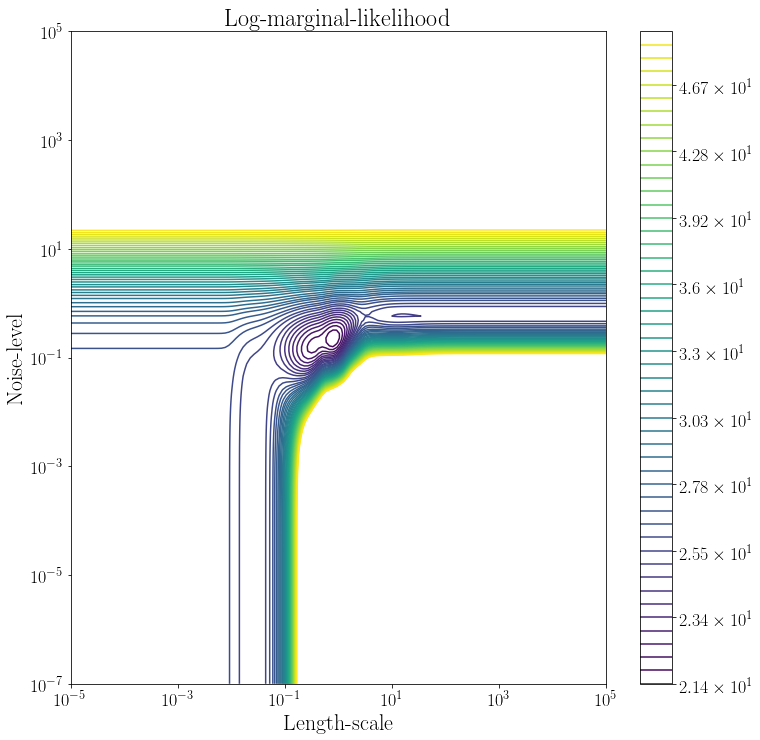

In [14]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(12, 12))
# Отрисовка логарифма правдоподобия
scale_range = np.logspace(-5, 5, 150)  # Диапазон значений scale-а
sigma2_range = np.logspace(-7, 5, 150) # Диапазон значений sigma^2
log_scale_range, log_sigma2_range = np.meshgrid(scale_range, sigma2_range)
LML = [[gpr.log_marginal_likelihood(np.log([log_scale_range[i, j], log_sigma2_range[i, j]]))
        for i in range(scale_range.shape[0])] for j in range(sigma2_range.shape[0])]
LML = np.array(LML).T
vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(log_scale_range, log_sigma2_range, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

Здесь имеется как минимум два локальных минимума, в которые может попасть процесс оптимизации.

Из графика видно, что адаптивный дизайн на порядки превосходит случайный равномерный дизайн. Что же касается OLHS, то данный метод в среднем ведет себя лучше случайного равномерно дизайна, однако его превосходство не столь значительно, как у адаптивного дизайна.